In [109]:
import numpy as np
from scipy.interpolate import BSpline, splrep, UnivariateSpline

from scipy.signal import bspline

import sparse
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from maskedtensor import masked_tensor


def generate_data(n_patients, n_var, T, idx_x, idx_y, rank):
    Fx = np.random.randn(n_var,rank)
    Fy = np.random.randn(rank)

    x_data = []
    y_data = []
    for i in range(n_patients):
        spl = [lambda t: 0.02*i*np.log(t+1), lambda t: 2*np.exp(-(t-60+10*i)/50*(t-60+10*i)+0.0000001) + 4*np.exp(-(t-70+10*i)/20*(t-70+10*i)+0.0000001) , lambda t: np.cos(0.12*np.pi*t) + 1]
        for j in range(n_var):
            tmp = np.matmul(Fx[j,:], [spl[r](idx_x[i,j,:].data) for r in range(rank)])+ 0.5*np.random.randn(len(idx_x[i,j,:].data))
            x_data = np.concatenate((x_data, tmp))
        tmp = np.matmul(Fy, [spl[r](idx_y[i,0,:].data) for r in range(rank)])+ 0.5*np.random.randn(len(idx_y[i,0,:].data))
        y_data = np.concatenate((y_data, tmp))
    output_x = sparse.COO(idx_x.coords, x_data, shape = (n_patients, n_var, T))
    output_y = sparse.COO(idx_y.coords, y_data, shape = (n_patients, 1, T))
    return [output_x, output_y, Fx, Fy]
############################
I = 33 # # of patients
J = 4 # # of variables for X
#T = 96 # max time
T = 1000
R = 3 # Rank
performance = {}

############# Multiresolution
idx_x = sparse.random((I, J, T), density = 0.8)
idx_y_train = sparse.random((I, 1, T), density = 0.2)

###Idx processing
idx_y_test = np.copy(idx_y_train)
idx_y_test.fill_value = np.nan
idx_y_test = np.isnan(idx_y_test.todense())
idx_y_test = sparse.COO.from_numpy(idx_y_test)
idx_y = idx_y_train+idx_y_test
idx_x.data = idx_x.coords[2,:]
idx_y_train.data = idx_y_train.coords[2,:]
idx_y_test.data = idx_y_test.coords[2,:]
idx_y.data = idx_y.coords[2,:]

[output_x, output_y, trueFx, trueFy] = generate_data(n_patients = I, n_var = J, T = T, idx_x = idx_x, idx_y = idx_y, rank = R)

idx_y_train_copy = np.copy(idx_y_train)
idx_y_train_copy.data = np.ones(len(idx_y_train_copy.data))
output_y_train = output_y * idx_y_train_copy

idx_y_test_copy = np.copy(idx_y_test)
idx_y_test_copy.data = np.ones(len(idx_y_test_copy.data))
output_y_test = output_y * idx_y_test_copy


output_y_train.fill_value = 0
output_y_test.fill_value = 0
output_x.fill_value = 0

In [131]:
def newdata():
    idx_x = sparse.random((I, J, T), density = 0.8)
    idx_y_train = sparse.random((I, 1, T), density = 0.2)
    idx_y_test = np.copy(idx_y_train)
    idx_y_test.fill_value = np.nan
    idx_y_test = np.isnan(idx_y_test.todense())
    idx_y_test = sparse.COO.from_numpy(idx_y_test)
    idx_y = idx_y_train+idx_y_test
    idx_x.data = idx_x.coords[2,:]
    idx_y_train.data = idx_y_train.coords[2,:]
    idx_y_test.data = idx_y_test.coords[2,:]
    idx_y.data = idx_y.coords[2,:]
    [output_x, output_y, trueFx, trueFy] = generate_data(n_patients = I, n_var = J, T = T, idx_x = idx_x, idx_y = idx_y, rank = R)
    idx_y_train_copy = np.copy(idx_y_train)
    idx_y_train_copy.data = np.ones(len(idx_y_train_copy.data))
    output_y_train = output_y * idx_y_train_copy
    idx_y_test_copy = np.copy(idx_y_test)
    idx_y_test_copy.data = np.ones(len(idx_y_test_copy.data))
    output_y_test = output_y * idx_y_test_copy
    output_y_train.fill_value = 0
    output_y_test.fill_value = 0
    output_x.fill_value = 0

In [4]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.A = nn.Sequential(
      nn.Linear(4, 32),
      nn.ReLU(),
      nn.Linear(32, 32),
      nn.ReLU(),
      nn.Linear(32, 32),
      nn.ReLU(),
      nn.Linear(32,3)
        
    )
    
    self.B = nn.Sequential(
        nn.Linear(3,1)
    )


  def forward(self, x):
    '''Forward pass'''
    x = torch.reshape(x,(-1, 33,4))
    x = self.A(x)
    x = torch.reshape(x, (-1, 3))
    print(x.size())
    x = self.B(x)
    x = torch.reshape(x, (1000,33,1))
    return x

In [5]:
x_train_tensor = torch.tensor(output_x.todense())
y_train_tensor = torch.tensor(output_y_train.todense())

y_test_tensor = torch.tensor(output_y_test.todense())

x_train_tensor = x_train_tensor.float()
y_train_tensor = y_train_tensor.float()
y_test_tensor = y_test_tensor.float()

x = torch.reshape(x_train_tensor, (-1, 1000))
x = x.T
# x = torch.reshape(x,(1000,33,4))
y = torch.reshape(y_train_tensor, (-1, 1000))
y = y.T
y = torch.reshape(y,(1000,33,1))
y_test = torch.reshape(y_test_tensor, (-1, 1000))
y_test = y_test.T
y_test = torch.reshape(y_test,(1000,33,1))
print(x.size())
print(y.size())

torch.Size([1000, 132])
torch.Size([1000, 33, 1])


torch.Size([33000, 3])


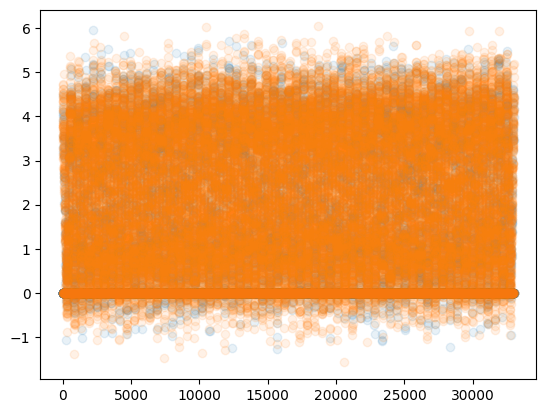

loss: 1.7669954299926758
true_loss: 6.914126873016357
training done: 1.7669954299926758


In [6]:


# Set fixed random number seed
torch.manual_seed(42)
epoch = 1
sum_loss = 0
# trainloader_x = torch.utils.data.DataLoader(x.T,batch_size=32)
# trainloader_y = torch.utils.data.DataLoader(y.T,batch_size=32)



# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
for i in range(epoch):
    # Run the training loop
    optimizer.zero_grad()
    
    # Iterate over the DataLoader for training data
    # for i, data in enumerate(trainloader):

    # Get inputs

    inputs , targets = x, y
    # Zero the gradients


    # Perform forward pass
    outputs = mlp(inputs)

    fig, ax = plt.subplots()
    y_print = torch.reshape(y,(-1,1))
    y_test_print = torch.reshape(y_test,(-1,1))
    # print(y_print.size())
    ax.scatter(range(33000),y_print,alpha = 0.1)
    ax.scatter(range(33000),y_test_print, alpha = 0.1)
    plt.show()


    # print(inputs.size(), outputs.size())
    # Compute loss
    loss = loss_function(outputs, targets)
    true_loss = loss_function(outputs, y_test)
    sum_loss = loss.item() + sum_loss
    
    #         if i%100 == 0:
    #             if i != 0:
    #                 print(sum_loss/i)

    # if last_loss<loss.item():
    #   break
    # last_loss = loss.item()

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Process is complete.
    print('loss:', loss.item())
    print("true_loss:", true_loss.item())
print("training done:", sum_loss/epoch)

In [7]:
# x2 = torch.cat([x_train_tensor,y_train_tensor],1)
# print(x2.size())
# x2 = torch.reshape(x2, (-1, 1000))
# x2 = x2.T
# print(x2.size())
# x2_test = torch.reshape(x2, (-1,33,5))
# x2 = torch.reshape(x2, (-1,1000))
# x2 = x2.T
# x2.size()

In [8]:
a = torch.from_numpy(output_x.todense().astype("float32"))
# a1= torch.reshape(a,(-1,1000))
# a2 = a1.T
# a3 = torch.reshape(a2,(-1,33,4))
b = torch.from_numpy(output_y_train.todense().astype("float32"))
# b1 = torch.reshape(b,(-1,1000))
# b2 = b1.T
# b3 = torch.reshape(b2,(-1,33,1))
# print("b:",b.shape)
# print("a:",a.shape)
data = torch.cat((a,b),1)
test_data = torch.reshape(data, (-1,1000))
test_data = test_data.T
test_data = torch.reshape(test_data,(-1,33,5))
print(test_data.shape)
train_data = torch.reshape(data,(-1,1000))
train_data = train_data.T
print("train:", train_data.shape)

torch.Size([1000, 33, 5])
train: torch.Size([1000, 165])


In [9]:
class MLP2(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.A = nn.Sequential(
      nn.Linear(5, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32,3),
      nn.Sigmoid()
    )
    
    self.B = nn.Sequential(
        nn.Linear(3,128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32,5),
        nn.Sigmoid()
    )


  def forward(self, x):
    '''Forward pass'''
    x = torch.reshape(x,(-1, 33,5))
    x = self.A(x)
    x = torch.reshape(x, (-1, 3))
    x = self.B(x)
    x = torch.reshape(x, (-1,33,5))
    return x
  


# Set fixed random number seed
torch.manual_seed(42)
epoch = 1
sum_loss = 0
# trainloader_x = torch.utils.data.DataLoader(x.T,batch_size=32)
# trainloader_y = torch.utils.data.DataLoader(y.T,batch_size=32)



# Initialize the MLP
mlp2 = MLP2()

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp2.parameters(), lr=1e-4)
for i in range(epoch):
    # Run the training loop
    optimizer.zero_grad()
    
    # Iterate over the DataLoader for training data
    # for i, data in enumerate(trainloader):

    # Get inputs

    inputs , targets = train_data, test_data
    # Zero the gradients


    # Perform forward pass
    outputs = mlp2(inputs)
    # print(inputs.size(), outputs.size())
    # Compute loss
    loss = loss_function(outputs, targets)
    sum_loss = loss.item() + sum_loss
    
    #         if i%100 == 0:
    #             if i != 0:
    #                 print(sum_loss/i)

    # if last_loss<loss.item():
    #   break
    # last_loss = loss.item()

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Process is complete.
    print('loss:', loss.item())
print("training done:", sum_loss/epoch)

loss: 4.207545280456543
training done: 4.207545280456543


In [10]:
test_mask = test_data.ne(0)
test_mask_y = test_data.eq(0)
train_data_mask = train_data.ne(0)
train_masked = masked_tensor(train_data, train_data_mask)


apply the mask

loss: 0.25096312165260315
training done:


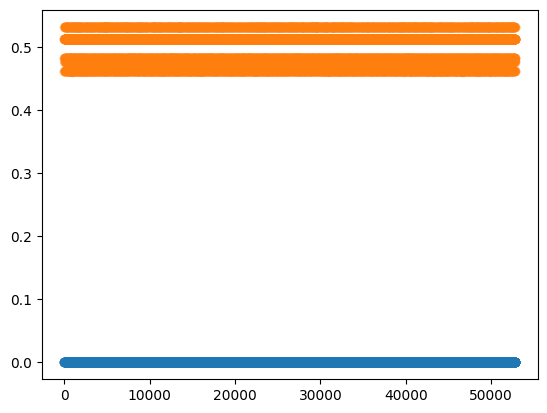

In [11]:

class MLP3(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.A = nn.Sequential(
      nn.Linear(5, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32,3),
      nn.Sigmoid()
    )
    
    self.B = nn.Sequential(
        nn.Linear(3,128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32,5),
        nn.Sigmoid()
    )


  def forward(self, x):
    '''Forward pass'''
    x = torch.reshape(x,(-1, 33,5))
    x = self.A(x)
    x = torch.reshape(x, (-1, 3))
    x = self.B(x)
    x = torch.reshape(x, (-1,33,5))
    return x
  


# Set fixed random number seed
torch.manual_seed(42)
epoch = 1
sum_loss = 0
# trainloader_x = torch.utils.data.DataLoader(x.T,batch_size=32)
# trainloader_y = torch.utils.data.DataLoader(y.T,batch_size=32)



# Initialize the MLP
mlp3 = MLP3()



# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp3.parameters(), lr=1e-4)
for i in range(epoch):
    # Run the training loop
    optimizer.zero_grad()
    
    # Iterate over the DataLoader for training data
    # for i, data in enumerate(trainloader):

    # Get inputs

    inputs , targets = train_data, test_data
    # Zero the gradients

    


    # Perform forward pass
    outputs = mlp3(inputs)
    # print(inputs.size(), outputs.size())
    # Compute loss
    # temp_loss = loss_function(outputs,)
    outputs = torch.masked_select(outputs, test_mask_y)
    targets = torch.masked_select(test_data, test_mask_y)
    loss = loss_function(outputs, targets)
    sum_loss = loss.item() + sum_loss
    
    #         if i%100 == 0:
    #             if i != 0:
    #                 print(sum_loss/i)

    # if last_loss<loss.item():
    #   break
    # last_loss = loss.item()

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Process is complete.
    print('loss:', loss.item())
print("training done:")
fig, ax = plt.subplots()
y_print = targets.detach().numpy()
y_test_print = outputs.detach().numpy()
# print(y_print.size())
ax.scatter(range(52800),y_print,alpha = 0.1)
ax.scatter(range(52800),y_test_print, alpha = 0.1)
plt.show()

In [12]:
a = torch.from_numpy(output_x.todense().astype("float32"))
# a1= torch.reshape(a,(-1,1000))
# a2 = a1.T
# a3 = torch.reshape(a2,(-1,33,4))
b = torch.from_numpy(output_y_train.todense().astype("float32"))
# b1 = torch.reshape(b,(-1,1000))
# b2 = b1.T
# b3 = torch.reshape(b2,(-1,33,1))
# print("b:",b.shape)
# print("a:",a.shape)
data = torch.cat((a,b),1)

data_for_train = data[:,:,0:800]
data_for_test = data[:,:,800:]

data = data_for_train

data_mask = data.eq(0)
data2 = torch.cat((a,b),1)[:,:,0:800]
data2.masked_fill_(data_mask,-99)
test_data = torch.reshape(data, (-1,800))
test_data = test_data.T
test_data = torch.reshape(test_data,(-1,33,5))
print(test_data.shape)
train_data2 = torch.reshape(data2,(-1,800))
train_data2 = train_data2.T
print("train:", train_data2.shape)

test_mask = test_data.ne(0)
test_mask_y = test_data.eq(0)
# train_data_mask = train_data.ne(0)
# train_masked = masked_tensor(train_data, train_data_mask)



torch.Size([800, 33, 5])
train: torch.Size([800, 165])


loss: 0.2495465725660324
loss: 0.24910689890384674
loss: 0.2486884444952011
loss: 0.24828125536441803
loss: 0.2478666454553604
loss: 0.2474474161863327
loss: 0.2470160871744156
loss: 0.24654579162597656
loss: 0.24606871604919434
loss: 0.24558986723423004
training done:


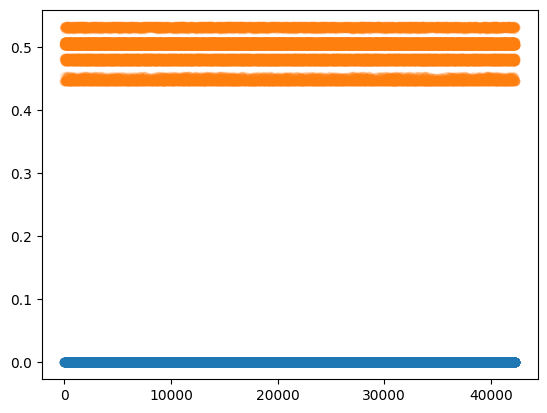

In [13]:

class MLP4(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.A = nn.Sequential(
      nn.Linear(5, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32,3),
      nn.Sigmoid()
    )
    
    self.B = nn.Sequential(
        nn.Linear(3,128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32,5),
        nn.Sigmoid()
    )


  def forward(self, x):
    '''Forward pass'''
    x = torch.reshape(x,(-1, 33,5))
    
    x = self.A(x)
    x = torch.reshape(x, (-1, 3))
    x = self.B(x)
    x = torch.reshape(x, (-1,33,5))
    return x
  


# Set fixed random number seed
torch.manual_seed(42)
epoch = 10
sum_loss = 0
# trainloader_x = torch.utils.data.DataLoader(x.T,batch_size=32)
# trainloader_y = torch.utils.data.DataLoader(y.T,batch_size=32)



# Initialize the MLP
mlp4 = MLP4()



# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp4.parameters(), lr=1e-4)
for i in range(epoch):
    # Run the training loop
    optimizer.zero_grad()
    
    # Iterate over the DataLoader for training data
    # for i, data in enumerate(trainloader):

    # Get inputs

    inputs , targets = train_data2, test_data
    # Zero the gradients

    


    # Perform forward pass
    outputs = mlp4(inputs)
    # print(inputs.size(), outputs.size())
    # Compute loss
    outputs = torch.masked_select(outputs, test_mask_y)
    targets = torch.masked_select(test_data, test_mask_y)
    loss = loss_function(outputs, targets)
    sum_loss = loss.item() + sum_loss
    
    #         if i%100 == 0:
    #             if i != 0:
    #                 print(sum_loss/i)

    # if last_loss<loss.item():
    #   break
    # last_loss = loss.item()

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Process is complete.
    print('loss:', loss.item())
print("training done:")
fig, ax = plt.subplots()
y_print = targets.detach().numpy()
y_test_print = outputs.detach().numpy()
# print(y_print.shape)
ax.scatter(range(y_print.size),y_print,alpha = 0.1)
ax.scatter(range(y_test_print.size),y_test_print, alpha = 0.1)
plt.show()

In [14]:
data = data_for_test

data_mask = data.eq(0)
data2 = torch.cat((a,b),1)[:,:,800:1000]
data2.masked_fill_(data_mask,-99)
test_data = torch.reshape(data, (-1,200))
test_data = test_data.T
test_data = torch.reshape(test_data,(-1,33,5))
print(test_data.shape)
train_data2 = torch.reshape(data2,(-1,200))
train_data2 = train_data2.T
print("train:", train_data2.shape)

test_mask = test_data.ne(0)
test_mask_y = test_data.eq(0)

torch.Size([200, 33, 5])
train: torch.Size([200, 165])


0.245065838098526


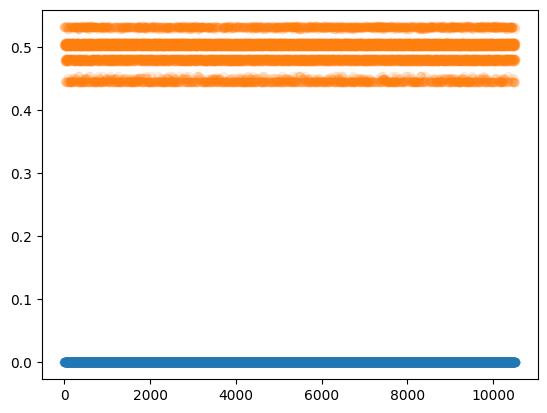

In [15]:
outputs = mlp4(train_data2)
# print(inputs.size(), outputs.size())
# Compute loss
outputs = torch.masked_select(outputs, test_mask_y)
targets = torch.masked_select(test_data, test_mask_y)
loss = loss_function(outputs, targets)
print(loss.item())
fig, ax = plt.subplots()
y_print = targets.detach().numpy()
y_test_print = outputs.detach().numpy()
# print(y_print.shape)
ax.scatter(range(y_print.size),y_print,alpha = 0.1)
ax.scatter(range(y_test_print.size),y_test_print, alpha = 0.1)
plt.show()

(100,)


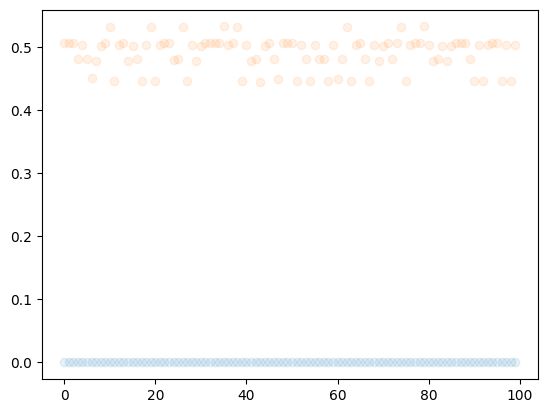

In [16]:
# detail plot
y_detail_print = y_print[1500:1600]
y_detail_test_print = y_test_print[1500:1600]
print(y_detail_print.shape)
fig, ax = plt.subplots()
ax.scatter(range(100),y_detail_print,alpha = 0.1)
ax.scatter(range(100),y_detail_test_print, alpha = 0.1)
plt.show()

In [17]:
# for presentation validation 
# only train for stress

In [18]:
a = torch.from_numpy(output_x.todense().astype("float32"))
# a1= torch.reshape(a,(-1,1000))
# a2 = a1.T
# a3 = torch.reshape(a2,(-1,33,4))
b = torch.from_numpy(output_y_train.todense().astype("float32"))
# b1 = torch.reshape(b,(-1,1000))
# b2 = b1.T
# b3 = torch.reshape(b2,(-1,33,1))
# print("b:",b.shape)
# print("a:",a.shape)
data = torch.cat((a,b),1)

data_for_train = data[:,:,0:800]
data_for_test = data[:,:,800:]

data = data_for_train


data_mask = data_for_train.eq(0)
data2 = torch.cat((a,b),1)[:,:,0:800]
data2.masked_fill_(data_mask,-99)

data2_test_mask = data_for_test.eq(0)
data2_test = torch.cat((a,b),1)[:,:,800:]
data2_test.masked_fill_(data2_test_mask,-99)
test_data2 = torch.reshape(data2_test,(-1,200))
test_data2 = test_data2.T


test_data = torch.reshape(data, (-1,800))
test_data = test_data.T
test_data = torch.reshape(test_data,(-1,33,5))
print(test_data.shape)
train_data2 = torch.reshape(data2,(-1,800))
train_data2 = train_data2.T
print("train:", train_data2.shape)

test_mask = test_data.ne(0)
test_mask_y = test_data.eq(0)
# train_data_mask = train_data.ne(0)
# train_masked = masked_tensor(train_data, train_data_mask)
stress_test = torch.from_numpy(output_y_test.todense().astype("float32"))
stress_test_mask = stress_test.eq(0)
stress_test.shape
stress_train = stress_test[:,:,0:800]
stress_test = stress_test[:,:,800:]

stress_train = torch.reshape(stress_train, (-1,800))
stress_train = stress_train.T
stress_train = torch.reshape(stress_train,(-1,33,1))
stress_train_mask = stress_train.ne(0)


stress_test = torch.reshape(stress_test, (-1,200))
stress_test = stress_test.T
stress_test = torch.reshape(stress_test,(-1,33,1))
stress_test_mask = stress_test.ne(0)




torch.Size([800, 33, 5])
train: torch.Size([800, 165])


loss: 8.337262153625488
loss: 2.192448139190674
loss: 2.1676955223083496
loss: 2.1611289978027344
loss: 2.1573774814605713
loss: 2.15354585647583
loss: 2.148564338684082
loss: 2.141388177871704
loss: 2.126432180404663
loss: 2.100386619567871
loss: 2.051304340362549
loss: 1.955318808555603
loss: 1.712896704673767
loss: 1.4064421653747559
loss: 1.2965394258499146
loss: 1.2534849643707275
loss: 1.2307796478271484
loss: 1.2159315347671509
loss: 1.207809567451477
loss: 1.2001005411148071
training done: 1.1951125860214233


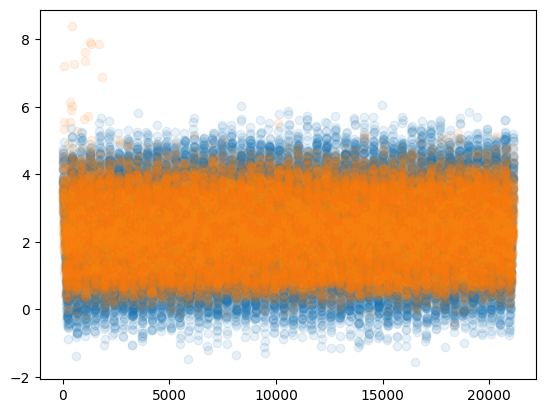

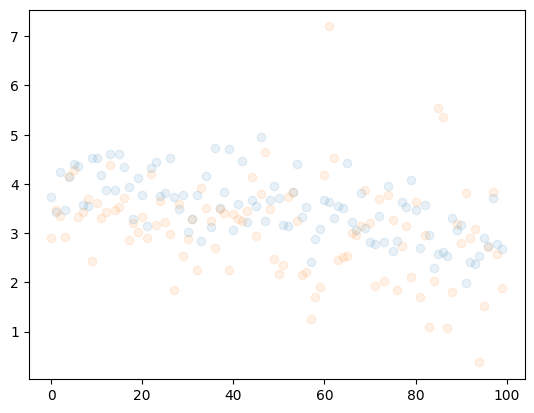

In [19]:

class MLP5(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.A = nn.Sequential(
      nn.Linear(5, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32,3)
    )
    
    self.B = nn.Sequential(
        nn.Linear(3,128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.Linear(64, 32),
        nn.Linear(32,1)
    )


  def forward(self, x):
    '''Forward pass'''
    x = torch.reshape(x,(-1, 33,5))
    
    x = self.A(x)
    x = torch.reshape(x, (-1, 3))
    x = self.B(x)
    x = torch.reshape(x, (-1,33,1))
    return x
  


# Set fixed random number seed
torch.manual_seed(42)
epoch = 2000
sum_loss = 0
# trainloader_x = torch.utils.data.DataLoader(x.T,batch_size=32)
# trainloader_y = torch.utils.data.DataLoader(y.T,batch_size=32)



# Initialize the MLP
mlp5 = MLP5()



# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp5.parameters(), lr=1e-4)
for i in range(epoch):
    # Run the training loop
    optimizer.zero_grad()
    
    # Iterate over the DataLoader for training data
    # for i, data in enumerate(trainloader):

    # Get inputs

    inputs = train_data2
    # Zero the gradients

    


    # Perform forward pass
    outputs = mlp5(inputs)
    # print(inputs.size(), outputs.size())
    # Compute loss
    outputs = torch.masked_select(outputs, stress_train_mask)
    targets = torch.masked_select(stress_train, stress_train_mask)
    loss = loss_function(outputs, targets)
    sum_loss = loss.item() + sum_loss
    
    #         if i%100 == 0:
    #             if i != 0:
    #                 print(sum_loss/i)

    # if last_loss<loss.item():
    #   break
    # last_loss = loss.item()

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Process is complete.
    if i%100 ==1:
      print('loss:', loss.item())
print("training done:",loss.item())
fig, ax = plt.subplots()
y_print = targets.detach().numpy()
y_test_print = outputs.detach().numpy()
# print(y_print.shape)
ax.scatter(range(y_print.size),y_print,alpha = 0.1)
ax.scatter(range(y_test_print.size),y_test_print, alpha = 0.1)
plt.show()
# detail plot
y_detail_print = y_print[0:100]
y_detail_test_print = y_test_print[0:100]
fig, ax = plt.subplots()
ax.scatter(range(100),y_detail_print,alpha = 0.1)
ax.scatter(range(100),y_detail_test_print, alpha = 0.1)
plt.show()


1.2233092784881592


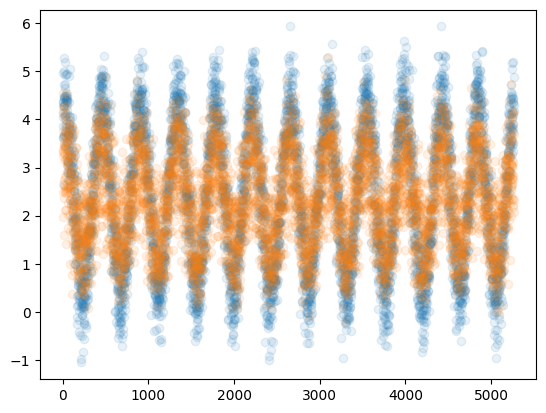

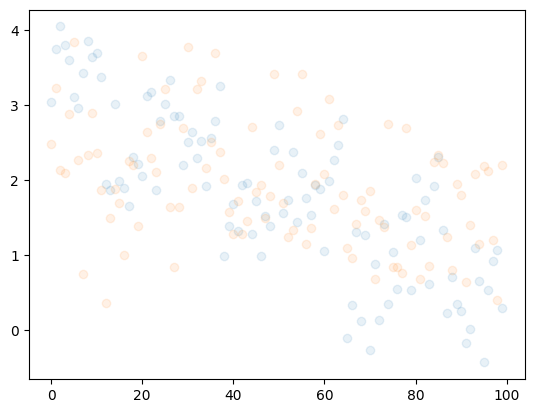

In [20]:
outputs = mlp5(test_data2)
# print(inputs.size(), outputs.size())
# Compute loss
outputs = torch.masked_select(outputs, stress_test_mask)
targets = torch.masked_select(stress_test, stress_test_mask)
loss = loss_function(outputs, targets)
print(loss.item())
fig, ax = plt.subplots()
y_print = targets.detach().numpy()
y_test_print = outputs.detach().numpy()
# print(y_print.shape)
ax.scatter(range(y_print.size),y_print,alpha = 0.1)
ax.scatter(range(y_test_print.size),y_test_print, alpha = 0.1)
plt.show()
# detail plot
y_detail_print = y_print[100:200]
y_detail_test_print = y_test_print[100:200]
fig, ax = plt.subplots()
ax.scatter(range(100),y_detail_print,alpha = 0.1)
ax.scatter(range(100),y_detail_test_print, alpha = 0.1)
plt.show()


In [21]:
# with open('readme.txt', 'a') as f:
#     f.write(str(loss.item()))
#     f.write("\n")

In [22]:
import pandas as pd


In [23]:
df = pd.read_csv("readme.txt",sep = ":",header=None)
df.mean()

0    1.093352
1    1.217960
dtype: float64

loss: 11.067961692810059
loss: 1.7030115127563477
loss: 1.5825409889221191
loss: 1.531777024269104
loss: 1.498826503753662
loss: 1.4914151430130005
loss: 1.4655088186264038
loss: 1.4411704540252686
loss: 1.4451086521148682
loss: 1.4166181087493896
training done: 1.410642147064209


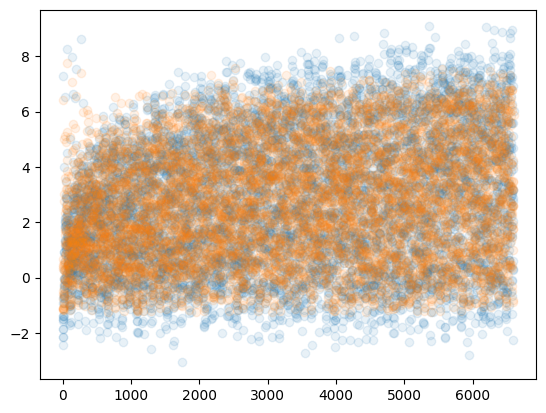

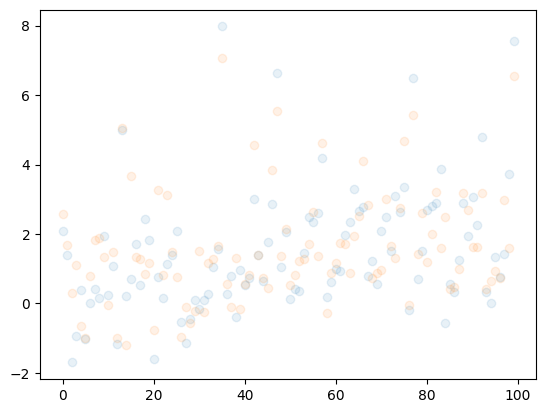

1.6977370977401733


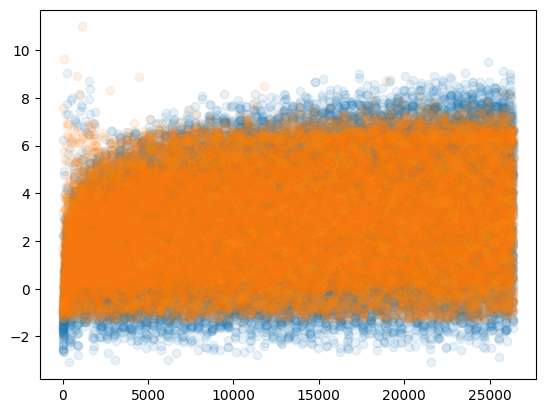

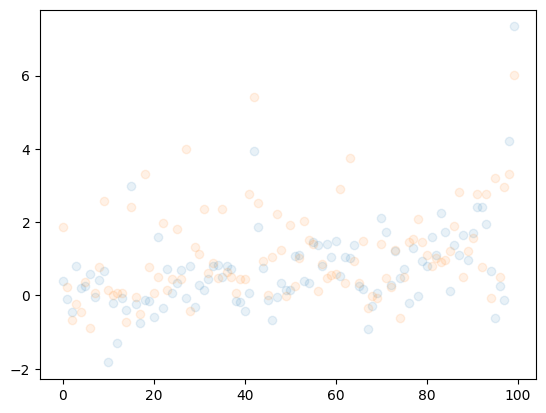

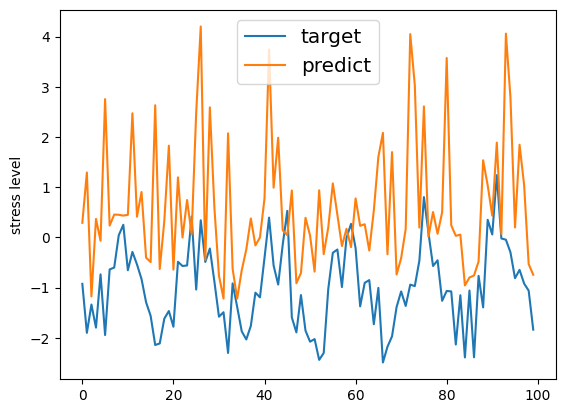

In [147]:

newdata()


a = torch.from_numpy(output_x.todense().astype("float32"))
b = torch.from_numpy(output_y_train.todense().astype("float32"))
data = a

data = torch.reshape(data,(-1,1000))
data = data.T



stress_test = torch.from_numpy(output_y_test.todense().astype("float32"))

stress_test = torch.reshape(stress_test, (-1,1000))
stress_test = stress_test.T
stress_test = torch.reshape(stress_test,(-1,33,1))
stress_test_mask = stress_test.ne(0)


stress_train = torch.from_numpy(output_y_train.todense().astype("float32"))

stress_train = torch.reshape(stress_train, (-1,1000))
stress_train = stress_train.T
stress_train = torch.reshape(stress_train,(-1,33,1))
stress_train_mask = stress_train.ne(0)





class MLP6(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.A = nn.Sequential(
      nn.Linear(4, 64),
      nn.ReLU(),
      nn.Linear(64,32),
      nn.ReLU(),
      nn.Linear(32,3),
      nn.ReLU()
    )
    
    self.B = nn.Sequential(
        nn.Linear(3,64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.Linear(32,1)
    )


  def forward(self, x):
    '''Forward pass'''
    x = torch.reshape(x,(-1, 33,4))
    
    x = self.A(x)
    x = torch.reshape(x, (-1, 3))
    x = self.B(x)
    x = torch.reshape(x, (-1,33,1))
    return x
  


# Set fixed random number seed
epoch = 1000
sum_loss = 0
# trainloader_x = torch.utils.data.DataLoader(x.T,batch_size=32)
# trainloader_y = torch.utils.data.DataLoader(y.T,batch_size=32)



# Initialize the MLP
mlp6 = MLP6()



# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp6.parameters(), lr=1e-2)
for i in range(epoch):
    # Run the training loop
    optimizer.zero_grad()
    
    # Iterate over the DataLoader for training data
    # for i, data in enumerate(trainloader):

    # Get inputs

    inputs = data
    # Zero the gradients

    


    # Perform forward pass
    outputs = mlp6(inputs)
    # print(inputs.size(), outputs.size())
    # Compute loss
    outputs = torch.masked_select(outputs, stress_train_mask)
    targets = torch.masked_select(stress_train, stress_train_mask)
    loss = loss_function(outputs, targets)
    sum_loss = loss.item() + sum_loss
    
    #         if i%100 == 0:
    #             if i != 0:
    #                 print(sum_loss/i)

    # if last_loss<loss.item():
    #   break
    # last_loss = loss.item()

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Process is complete.
    if i%100 ==1:
      print('loss:', loss.item())
print("training done:",loss.item())
fig, ax = plt.subplots()
y_print = targets.detach().numpy()
y_test_print = outputs.detach().numpy()
# print(y_print.shape)
ax.scatter(range(y_print.size),y_print,alpha = 0.1)
ax.scatter(range(y_test_print.size),y_test_print, alpha = 0.1)
plt.show()
# detail plot
y_detail_print = y_print[100:200]
y_detail_test_print = y_test_print[100:200]
fig, ax = plt.subplots()
ax.scatter(range(100),y_detail_print,alpha = 0.1)
ax.scatter(range(100),y_detail_test_print, alpha = 0.1)
plt.show()


outputs = mlp6(data)
# print(inputs.size(), outputs.size())
# Compute loss
outputs = torch.masked_select(outputs, stress_test_mask)
targets = torch.masked_select(stress_test, stress_test_mask)
loss = loss_function(outputs, targets)
print(loss.item())
fig, ax = plt.subplots()
y_print = targets.detach().numpy()
y_test_print = outputs.detach().numpy()
# print(y_print.shape)
ax.scatter(range(y_print.size),y_print,alpha = 0.1)
ax.scatter(range(y_test_print.size),y_test_print, alpha = 0.1)
plt.show()
# detail plot
y_detail_print = y_print[100:200]
y_detail_test_print = y_test_print[100:200]
fig, ax = plt.subplots()
ax.scatter(range(100),y_detail_print,alpha = 0.1)
ax.scatter(range(100),y_detail_test_print, alpha = 0.1)
plt.show()
sample1_predict = []
sample1_real = []
outputs = mlp6(data)
outputs = outputs.detach().numpy()
stress = torch.add(stress_test, stress_train)
stress = stress.detach().numpy()

start_point = 500
end_point = 600
for i in range(start_point,end_point):
    
    sample1_predict.append(outputs[i,0,0])
    sample1_real.append(stress[i,0,0])
fig, ax = plt.subplots()
ax.plot(range(100),sample1_real,label = "target", alpha = 1)
ax.plot(range(100),sample1_predict, label = "predict", alpha = 1)
ax.legend(loc = "upper center",fontsize = "x-large")
plt.ylabel("stress level")
plt.show()


In [161]:
mse_train_list = []
mse_test_list = []
for iteration in range(1):
    

    # idx_x = sparse.random((I, J, T), density = 0.8)
    # idx_y_train = sparse.random((I, 1, T), density = 0.2)

    # ###Idx processing
    # idx_y_test = np.copy(idx_y_train)
    # idx_y_test.fill_value = np.nan
    # idx_y_test = np.isnan(idx_y_test.todense())
    # idx_y_test = sparse.COO.from_numpy(idx_y_test)
    # idx_y = idx_y_train+idx_y_test
    # idx_x.data = idx_x.coords[2,:]
    # idx_y_train.data = idx_y_train.coords[2,:]
    # idx_y_test.data = idx_y_test.coords[2,:]
    # idx_y.data = idx_y.coords[2,:]

    # [output_x, output_y, trueFx, trueFy] = generate_data(n_patients = I, n_var = J, T = T, idx_x = idx_x, idx_y = idx_y, rank = R)

    # idx_y_train_copy = np.copy(idx_y_train)
    # idx_y_train_copy.data = np.ones(len(idx_y_train_copy.data))
    # output_y_train = output_y * idx_y_train_copy

    # idx_y_test_copy = np.copy(idx_y_test)
    # idx_y_test_copy.data = np.ones(len(idx_y_test_copy.data))
    # output_y_test = output_y * idx_y_test_copy


    # output_y_train.fill_value = 0
    # output_y_test.fill_value = 0
    # output_x.fill_value = 0


    a = torch.from_numpy(output_x.todense().astype("float32"))
    b = torch.from_numpy(output_y_train.todense().astype("float32"))
    data = a

    data = torch.reshape(data,(-1,1000))
    data = data.T



    stress_test = torch.from_numpy(output_y_test.todense().astype("float32"))

    stress_test = torch.reshape(stress_test, (-1,1000))
    stress_test = stress_test.T
    stress_test = torch.reshape(stress_test,(-1,33,1))
    stress_test_mask = stress_test.ne(0)


    stress_train = torch.from_numpy(output_y_train.todense().astype("float32"))

    stress_train = torch.reshape(stress_train, (-1,1000))
    stress_train = stress_train.T
    stress_train = torch.reshape(stress_train,(-1,33,1))
    stress_train_mask = stress_train.ne(0)




    epoch = 1000
    mlp6 = MLP6()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp6.parameters(), lr=1e-2)
    for i in range(epoch):
        # Run the training loop
        optimizer.zero_grad()
        inputs = data
        # Zero the gradients
        # Perform forward pass
        outputs = mlp6(inputs)
        # print(inputs.size(), outputs.size())
        # Compute loss
        outputs = torch.masked_select(outputs, stress_train_mask)
        targets = torch.masked_select(stress_train, stress_train_mask)
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Process is complete.
        if i%500 ==1:
            print('loss:', loss.item())
    print("epoch:",iteration)
    print("training done:",loss.item())
    mse_train_list.append(loss.item())


    outputs = mlp6(data)
    # print(inputs.size(), outputs.size())
    # Compute loss
    outputs = torch.masked_select(outputs, stress_test_mask)
    targets = torch.masked_select(stress_test, stress_test_mask)
    loss = loss_function(outputs, targets)
    mse_test_list.append(loss.item())
    print(loss.item())

mse_train_list = np.array(mse_train_list)
mse_test_list = np.array(mse_test_list)
print("MSE for training:")
print(mse_train_list.mean(),mse_train_list.std())
print("MSE for testing:")
print(mse_test_list.mean(),mse_test_list.std()) 

loss: 0.5865209102630615
loss: 0.279579222202301
epoch: 0
training done: 0.26741093397140503
0.35511040687561035
MSE for training:
0.26741093397140503 0.0
MSE for testing:
0.35511040687561035 0.0


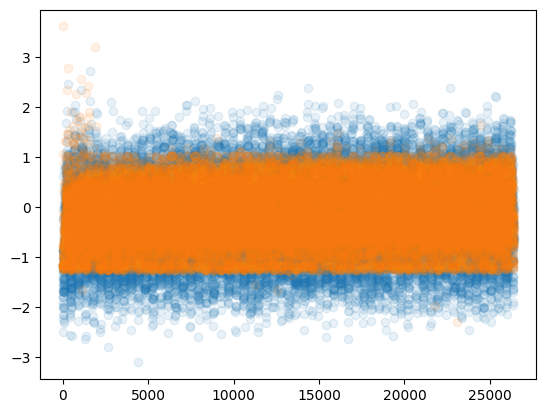

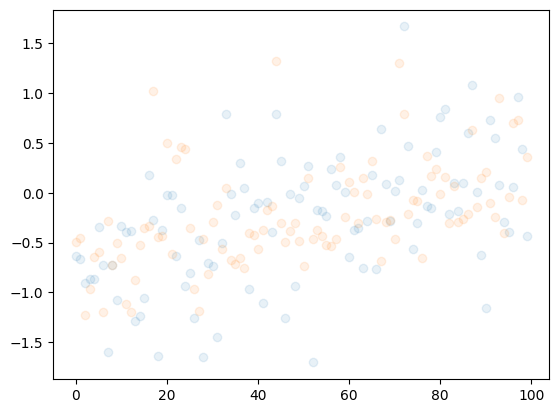

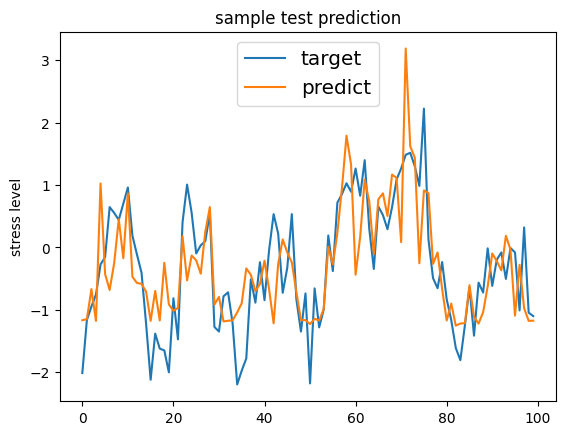

In [162]:

fig, ax = plt.subplots()
y_print = targets.detach().numpy()
y_test_print = outputs.detach().numpy()
# print(y_print.shape)
ax.scatter(range(y_print.size),y_print,alpha = 0.1)
ax.scatter(range(y_test_print.size),y_test_print, alpha = 0.1)
plt.show()
# detail plot
y_detail_print = y_print[100:200]
y_detail_test_print = y_test_print[100:200]
fig, ax = plt.subplots()
ax.scatter(range(100),y_detail_print,alpha = 0.1)
ax.scatter(range(100),y_detail_test_print, alpha = 0.1)
plt.show()
sample1_predict = []
sample1_real = []
outputs = mlp6(data)
outputs = outputs.detach().numpy()
stress = torch.add(stress_test, stress_train)
stress = stress.detach().numpy()

start_point = 0
end_point = 100
for i in range(start_point,end_point):
    
    sample1_predict.append(outputs[i,0,0])
    sample1_real.append(stress[i,0,0])
fig, ax = plt.subplots()
ax.plot(range(100),sample1_real,label = "target", alpha = 1)
ax.plot(range(100),sample1_predict, label = "predict", alpha = 1)
ax.legend(loc = "upper center",fontsize = "x-large")
plt.ylabel("stress level")
plt.title("sample test prediction")
plt.show()


In [129]:
# pd.DataFrame(mse_train_list).to_csv("MLP6_train_MSE.csv")
# pd.DataFrame(mse_test_list).to_csv("MLP6_test_MSE.csv")
print("MSE for training:")
print(mse_train_list.mean(),mse_train_list.std())
print("MSE for testing:")
print(mse_test_list.mean(),mse_test_list.std()) 

MSE for training:
0.7835267698764801 0.7420903863830226
MSE for testing:
1.0370627373456955 0.9796453668912415


In [130]:
df_train = pd.read_csv("MLP6_train_MSE.csv", header=None,index_col=0)
df_test = pd.read_csv("MLP6_test_MSE.csv",header=None,index_col=0)
print("MSE for training:")
print(np.array(df_train).mean(),np.array(df_train).std())
print("MSE for testing:")
print(np.array(df_test).mean(),np.array(df_test).std()) 

MSE for training:
0.48512278672526865 0.26005547791050937
MSE for testing:
0.5352545672771978 0.28342386258429614


In [165]:

a = torch.from_numpy(output_x.todense().astype("float32"))
b = torch.from_numpy(output_y_train.todense().astype("float32"))
data = torch.cat((a,b),1)

data = torch.reshape(data,(-1,1000))
data = data.T
data = torch.reshape(data,(100,10,-1))
data = torch.reshape(data,(100,-1))



stress_test = torch.from_numpy(output_y_test.todense().astype("float32"))

stress_test = torch.reshape(stress_test, (-1,1000))
stress_test = stress_test.T
stress_test = torch.reshape(stress_test,(-1,33,1))
stress_test = torch.reshape(stress_test,(-1,33,10))
stress_test_mask = stress_test.ne(0)


stress_train = torch.from_numpy(output_y_train.todense().astype("float32"))

stress_train = torch.reshape(stress_train, (-1,1000))
stress_train = stress_train.T
stress_train = torch.reshape(stress_train,(-1,33,1))
stress_train = torch.reshape(stress_train,(-1,33,10))
stress_train_mask = stress_train.ne(0)

class MLP7(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.A = nn.Sequential(
      nn.Linear(50, 640),
      nn.ReLU(),
      nn.Linear(640,320),
      nn.Linear(320,160),
      
      nn.Linear(160,30)
    )
    
    self.B = nn.Sequential(
        nn.Linear(30,640),
        nn.ReLU(),
        nn.Linear(640, 320),
        nn.Linear(320,160),
        nn.Linear(160,10)
    )


  def forward(self, x):
    '''Forward pass'''
    x = torch.reshape(x,(-1, 33,50))
    
    x = self.A(x)
    x = torch.reshape(x, (-1, 30))
    x = self.B(x)
    x = torch.reshape(x, (100,33,10))
    return x
  




epoch = 100
mlp7 = MLP7()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp7.parameters(), lr=1e-4)
for i in range(epoch):
    # Run the training loop
    optimizer.zero_grad()
    inputs = data
    # Zero the gradients
    # Perform forward pass
    outputs = mlp7(inputs)
    # print(inputs.size(), outputs.size())
    # Compute loss
    outputs = torch.masked_select(outputs, stress_train_mask)
    targets = torch.masked_select(stress_train, stress_train_mask)
    loss = loss_function(outputs, targets)
    
    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Process is complete.
    if i%500 ==1:
        print('loss:', loss.item())
print("epoch:",iteration)
print("training done:",loss.item())

outputs = mlp7(data)
# print(inputs.size(), outputs.size())
# Compute loss
outputs = torch.masked_select(outputs, stress_test_mask)
targets = torch.masked_select(stress_test, stress_test_mask)
loss = loss_function(outputs, targets)
print(loss.item())

loss: 0.6472791433334351
epoch: 0
training done: 0.1920606642961502
0.30836689472198486


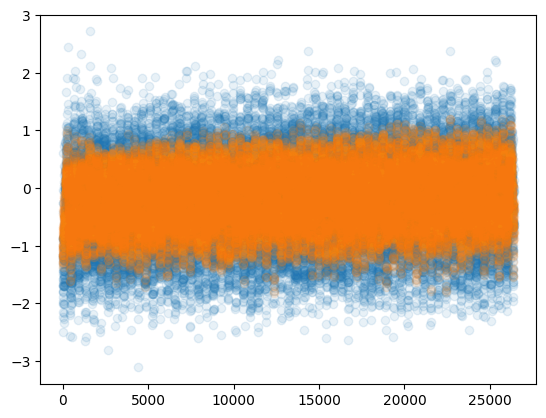

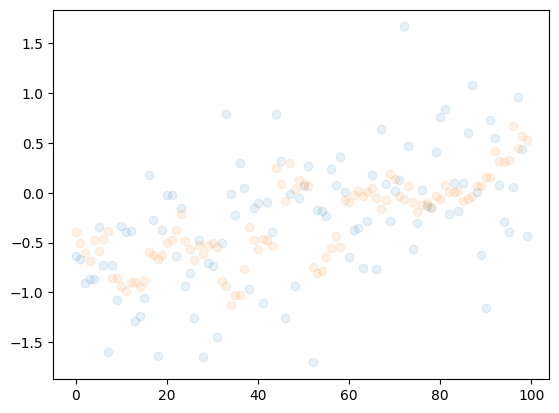

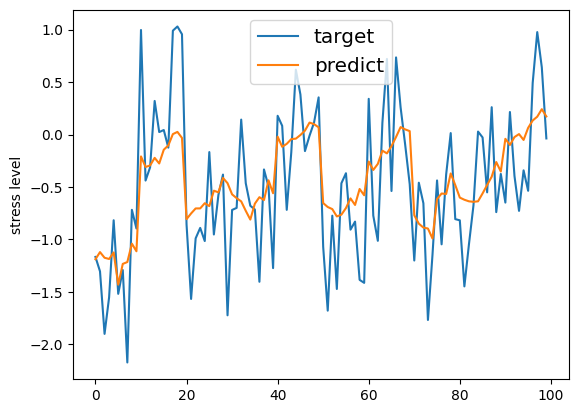

In [166]:
fig, ax = plt.subplots()
y_print = targets.detach().numpy()
y_test_print = outputs.detach().numpy()
# print(y_print.shape)
ax.scatter(range(y_print.size),y_print,alpha = 0.1)
ax.scatter(range(y_test_print.size),y_test_print, alpha = 0.1)
plt.show()
# detail plot
y_detail_print = y_print[100:200]
y_detail_test_print = y_test_print[100:200]
fig, ax = plt.subplots()
ax.scatter(range(100),y_detail_print,alpha = 0.1)
ax.scatter(range(100),y_detail_test_print, alpha = 0.1)
plt.show()

sample1_predict = []
sample1_real = []
outputs = mlp7(data)
outputs123 = outputs.detach().numpy()
stress = torch.add(stress_test, stress_train)
stress = stress.detach().numpy()

start_point = 50
end_point = 60
for i in range(start_point,end_point):
    for i2 in range(10):
        sample1_predict.append(outputs123[i,0,i2])
        sample1_real.append(stress[i,0,i2])

fig, ax = plt.subplots()
ax.plot(range(100),sample1_real,label = "target", alpha = 1)
ax.plot(range(100),sample1_predict, label = "predict", alpha = 1)
ax.legend(loc = "upper center",fontsize = "x-large")
plt.ylabel("stress level")
plt.show()

In [119]:
mse_train_list = []
mse_test_list = []
for iteration in range(50):
    
    # generate data
    idx_x = sparse.random((I, J, T), density = 0.8)
    idx_y_train = sparse.random((I, 1, T), density = 0.2)
    idx_y_test = np.copy(idx_y_train)
    idx_y_test.fill_value = np.nan
    idx_y_test = np.isnan(idx_y_test.todense())
    idx_y_test = sparse.COO.from_numpy(idx_y_test)
    idx_y = idx_y_train+idx_y_test
    idx_x.data = idx_x.coords[2,:]
    idx_y_train.data = idx_y_train.coords[2,:]
    idx_y_test.data = idx_y_test.coords[2,:]
    idx_y.data = idx_y.coords[2,:]
    [output_x, output_y, trueFx, trueFy] = generate_data(n_patients = I, n_var = J, T = T, idx_x = idx_x, idx_y = idx_y, rank = R)
    idx_y_train_copy = np.copy(idx_y_train)
    idx_y_train_copy.data = np.ones(len(idx_y_train_copy.data))
    output_y_train = output_y * idx_y_train_copy
    idx_y_test_copy = np.copy(idx_y_test)
    idx_y_test_copy.data = np.ones(len(idx_y_test_copy.data))
    output_y_test = output_y * idx_y_test_copy
    output_y_train.fill_value = 0
    output_y_test.fill_value = 0
    output_x.fill_value = 0

    #preprocessing
    a = torch.from_numpy(output_x.todense().astype("float32"))
    b = torch.from_numpy(output_y_train.todense().astype("float32"))
    data = torch.cat((a,b),1)
    data = torch.reshape(data,(-1,1000))
    data = data.T
    data = torch.reshape(data,(100,10,-1))
    data = torch.reshape(data,(100,-1))
    stress_test = torch.from_numpy(output_y_test.todense().astype("float32"))
    stress_test = torch.reshape(stress_test, (-1,1000))
    stress_test = stress_test.T
    stress_test = torch.reshape(stress_test,(-1,33,1))
    stress_test = torch.reshape(stress_test,(-1,33,10))
    stress_test_mask = stress_test.ne(0)
    stress_train = torch.from_numpy(output_y_train.todense().astype("float32"))
    stress_train = torch.reshape(stress_train, (-1,1000))
    stress_train = stress_train.T
    stress_train = torch.reshape(stress_train,(-1,33,1))
    stress_train = torch.reshape(stress_train,(-1,33,10))
    stress_train_mask = stress_train.ne(0)


    #training
    epoch = 100
    i = epoch
    mlp7 = MLP7()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp7.parameters(), lr=1e-4)
    while(i>0):
        i = i-1
        # Run the training loop
        optimizer.zero_grad()
        inputs = data
        # Zero the gradients
        # Perform forward pass
        outputs = mlp7(inputs)
        # print(inputs.size(), outputs.size())
        # Compute loss
        outputs = torch.masked_select(outputs, stress_train_mask)
        targets = torch.masked_select(stress_train, stress_train_mask)
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()


        # if loss.item()<0.2:
        #     break

        # if loss.item()>1:
        #     i = 20

    print("epoch:",iteration)
    print("training done:",loss.item())
    mse_train_list.append(loss.item())


    outputs = mlp7(data)
    # print(inputs.size(), outputs.size())
    # Compute loss
    outputs = torch.masked_select(outputs, stress_test_mask)
    targets = torch.masked_select(stress_test, stress_test_mask)
    loss = loss_function(outputs, targets)
    mse_test_list.append(loss.item())
    print(loss.item())
#summary
mse_train_list = np.array(mse_train_list)
mse_test_list = np.array(mse_test_list)
print("MSE for training:")
print(mse_train_list.mean(),mse_train_list.std())
print("MSE for testing:")
print(mse_test_list.mean(),mse_test_list.std()) 

epoch: 0
training done: 0.9912804961204529
1.1044315099716187
epoch: 1
training done: 2.8685500621795654
3.5884182453155518
epoch: 2
training done: 0.4588055908679962
0.5296527743339539
epoch: 3
training done: 0.29236021637916565
0.3641888499259949
epoch: 4
training done: 4.148978233337402
5.3718037605285645
epoch: 5
training done: 0.19904345273971558
0.2811163663864136
epoch: 6
training done: 0.8368607759475708
1.0314112901687622
epoch: 7
training done: 0.6014755964279175
0.7662753462791443
epoch: 8
training done: 0.555076003074646
0.6283487677574158
epoch: 9
training done: 0.7347748279571533
0.8924227356910706
epoch: 10
training done: 0.9155346751213074
1.5590696334838867
epoch: 11
training done: 0.32687467336654663
0.37560564279556274
epoch: 12
training done: 0.45290109515190125
0.5572685599327087
epoch: 13
training done: 1.0721409320831299
1.1861296892166138
epoch: 14
training done: 1.057629942893982
1.3479045629501343
epoch: 15
training done: 0.3794400990009308
0.49058324098587036

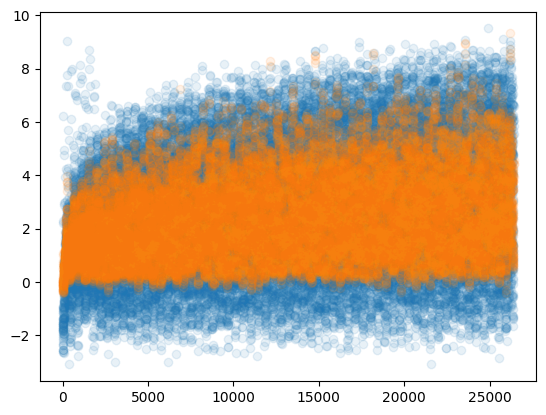

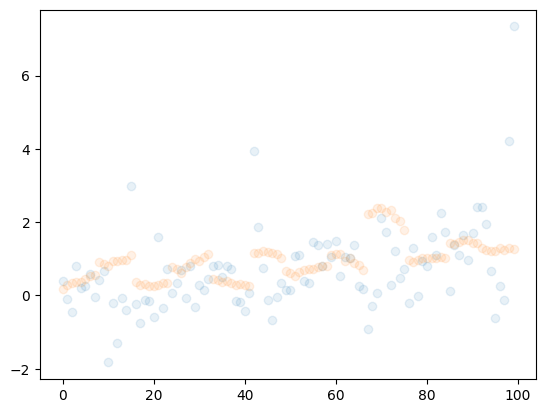

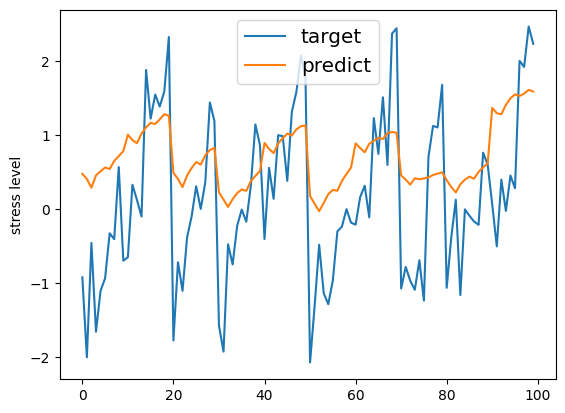

In [120]:
# pd.DataFrame(mse_train_list).to_csv("MLP7_train_MSE.csv")
# pd.DataFrame(mse_test_list).to_csv("MLP7_test_MSE.csv")
fig, ax = plt.subplots()
y_print = targets.detach().numpy()
y_test_print = outputs.detach().numpy()
# print(y_print.shape)
ax.scatter(range(y_print.size),y_print,alpha = 0.1)
ax.scatter(range(y_test_print.size),y_test_print, alpha = 0.1)
plt.show()
# detail plot
y_detail_print = y_print[100:200]
y_detail_test_print = y_test_print[100:200]
fig, ax = plt.subplots()
ax.scatter(range(100),y_detail_print,alpha = 0.1)
ax.scatter(range(100),y_detail_test_print, alpha = 0.1)
plt.show()


sample1_predict = []
sample1_real = []
outputs = mlp7(data)
outputs = outputs.detach().numpy()
stress = torch.add(stress_test, stress_train)
stress = stress.detach().numpy()

start_point = 50
end_point = 60
for i in range(start_point,end_point):
    for i2 in range(10):
        sample1_predict.append(outputs[i,0,i2])
        sample1_real.append(stress[i,0,i2])

fig, ax = plt.subplots()
ax.plot(range(100),sample1_real,label = "target", alpha = 1)
ax.plot(range(100),sample1_predict, label = "predict", alpha = 1)
ax.legend(loc = "upper center",fontsize = "x-large")
plt.ylabel("stress level")
plt.show()

In [167]:
df_train = pd.read_csv("MLP7_train_MSE.csv", header=None,index_col=0)
df_test = pd.read_csv("MLP7_test_MSE.csv",header=None,index_col=0)
print("MSE for training:")
print(np.array(df_train).mean(),np.array(df_train).std())
print("MSE for testing:")
print(np.array(df_test).mean(),np.array(df_test).std()) 

MSE for training:
0.48534075725896686 0.6425649527563594
MSE for testing:
0.8595082590392992 1.241466314419253
